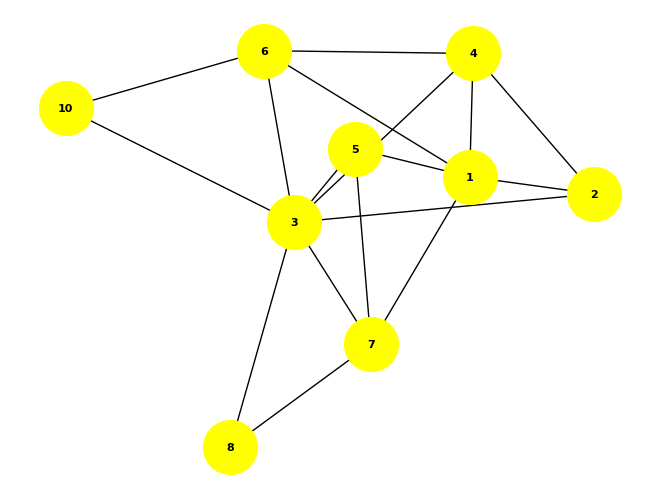

In [22]:
import yaml
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
edge_list = [[1,7], [1,2], [1,4], [1,6],
             [2,1], [2,4], [2,3],
             [3,2], [3,4], [3,6], [3,5], [3,7], [3,8], [3,10],
             [4,1], [4,2], [4,3],[4,6], 
             [5,1], [5,3], [5,7],
             [6,4], [6,3], [6,10],
             [7,5], [7,3], [7,8],
             [8,3], [8,7],
             [10,3],[10,6]]
def plot_input_graph(edge_list):
    edges = np.unique(edge_list, axis=1)
    G = nx.from_edgelist(edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=1500, node_color='yellow', font_size=8, font_weight='bold',with_labels=True)
    plt.savefig("../output/input_graph.png")
def get_neigbours_yaml(edge_list):
    neighbours = {}
    vertices = np.unique(edge_list)
    for vertix in vertices:
        neighbours_v = []
        for edge in edge_list:
            if np.any(edge ==vertix):
                neighbour=int(edge[int(np.where(edge != vertix)[0])])
                if neighbour not in neighbours_v:
                    neighbours_v.append(neighbour)
        neighbours_v.sort(reverse=True)
        neighbours[int(vertix)] = neighbours_v
    with open('neighbours.yml', 'w') as outfile:
        yaml.dump(neighbours, outfile, default_flow_style=False)
get_neigbours_yaml(edge_list)
plot_input_graph(edge_list)

In [23]:
def write_docker_compose_yml(edge_list,port):
    vertices = np.unique(edge_list)
    compose_file = {}
    compose_file["version"]="3"
    

    services = {}
    with open("ip_configuration.yml",'r') as file_ip:
        dict_ip = yaml.safe_load(file_ip)
    for v in vertices:
        node=       {"build":
                        {"context": ".",
                         "args":
                            {"PORT":port, "NODE_ID":int(v)}}, 
                    "networks": 
                        {"frontend": 
                            {"ipv4_address": dict_ip.get(int(v))}},
                    "command":"/bin/sh -c 'python3 dfs_server1.py'", 
                    "container_name":"node{}".format(int(v)),
                    "volumes":["./output:/grpc-docker/ddfs/output"],
                    }
        services["n{}".format(int(v))]=node

    compose_file["services"]= services
    compose_file["networks"]= {"frontend":
                                    {"ipam":
                                        {"config":
                                            [{"subnet":"172.20.0.0/24"}],
                                        }
                                    }
                                }                
    with open('../docker-compose.yml', 'w') as outfile:
        yaml.dump(compose_file, outfile, default_flow_style=False)
    
write_docker_compose_yml(edge_list,50051)
